## safecity dataset model


In [3]:
import numpy as np
import pandas as pd
import sys, os, re, csv, codecs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Conv1D, concatenate, Flatten, Concatenate
from tensorflow.keras.layers import  BatchNormalization, Dropout, Activation, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [5]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score 

### reading and formatting the dataset for training


In [6]:
multi_train = pd.read_csv('train.csv')

multi_validation = pd.read_csv('dev.csv')

multi_test = pd.read_csv('test.csv')

In [7]:
multi_train.head()

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [12]:

multi_train.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"}, inplace=True)
multi_validation.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)
multi_test.rename(columns={"Ogling/Facial Expressions/Staring": "Staring", "Touching /Groping": "Touching"},inplace=True)

In [14]:
# removing the duplicates to avoid clash

multi_train.drop_duplicates(keep = 'first', inplace=True)
multi_validation.drop_duplicates(keep = 'first', inplace=True)
multi_test.drop_duplicates(keep = 'first', inplace=True)

In [15]:
train = pd.concat([multi_train, multi_validation], axis=0 ) # concatinating the train and validation set 
train.head()

,Description,Commenting,Staring,Touching
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0


In [16]:
test = multi_test  
train.shape, test.shape

((7735, 4), (1640, 4))

In [17]:
y_train = train[['Commenting', 'Staring', 'Touching']].values
y_test = test[['Commenting', 'Staring', 'Touching']].values

### tokenizing the text and padding for fasttext

In [18]:
# Text Data 
description_train_text =list(train['Description'].values)
description_test_text = list(test['Description'].values)

# tokenizing
tokenizer = tf.keras.preprocessing.text.Tokenizer()
# fit on training data
tokenizer.fit_on_texts(description_train_text)     
train_description_sequences = tokenizer.texts_to_sequences(description_train_text)
test_description_sequences = tokenizer.texts_to_sequences(description_test_text)


vocab_size = len(tokenizer.word_index) + 1

# padding

train_description_padded = pad_sequences(
        train_description_sequences, maxlen=300, dtype='int32', padding='post',  
        truncating='post')                                                  

test_description_padded = pad_sequences(
        test_description_sequences, maxlen=300, dtype='int32', padding='post', 
        truncating='post')                                  

#### some metrics


In [19]:
# Exact match ratio
def exact_match_ratio(y_true, y_pred):
    global MR
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

In [20]:
# conver probabilities to labels

def prob_to_class(arr):   # converts probailities to class labes based on 0.5 threshold
    global r,c 
    r,c = arr.shape
    global predict
    predict =np.zeros((r, c))
    for i in range(r):
        for j in range(c):
            if arr[i,j]>0.5:
                predict[i,j] = 1
    return predict

### fasttext embeddings

In [24]:
from gensim.models.fasttext import FastText
%matplotlib inline 
import nltk

In [25]:
embedding_size = 300  #  size of the embedding vector
window_size = 20    # size of the number of words occurring before and after
min_word = 5  # minimum frequency of a word 
down_sampling = 1e-2   # most frequently occurring word will be randomly down sampled 

In [26]:
word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in description_train_text]

In [31]:
%%time     
ft_model = FastText(word_tokenized_corpus,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=100)

CPU times: user 8min 14s, sys: 1.99 s, total: 8min 16s
Wall time: 2min 49s


In [32]:
embedding_matrix_fast_text = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = ft_model.wv[word] 
  except:
    embedding_vector = np.zeros(300)
  
  if embedding_vector is not None:
    embedding_matrix_fast_text[i] = embedding_vector

## bilstm + cnn 1D

In [33]:
max_input=300
inputs = Input(shape=(max_input,))  # input 
embedding = Embedding(vocab_size, embedding_size, trainable=False) 

embedding.build((None,))
embedding.set_weights([embedding_matrix_fast_text])
embeddings = embedding(inputs)

x = SpatialDropout1D(0.35)(embeddings)

x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))(x)
x = Conv1D(64, kernel_size=3, padding='valid', kernel_initializer='glorot_uniform')(x)

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)  

x = concatenate([avg_pool, max_pool])

x = BatchNormalization()(x)

x = Dropout(0.2)(x)   

x = Dense(64, activation='relu')(x)

x = Dropout(0.2)(x)   

outputs = Dense(3, activation='sigmoid')(x)  # output

model_4_fast_text = Model(inputs=inputs, outputs = outputs)  # model

In [34]:
model_4_fast_text.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
history = model_4_fast_text.fit(train_description_padded, y_train, batch_size=64, epochs=10, validation_data=(test_description_padded, y_test))  

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 54s 432ms/step - binary_accuracy: 0.6535 - loss: 0.6365 - val_binary_accuracy: 0.8010 - val_loss: 0.5224
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 426ms/step - binary_accuracy: 0.8027 - loss: 0.4667 - val_binary_accuracy: 0.8266 - val_loss: 0.4318
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 425ms/step - binary_accuracy: 0.8282 - loss: 0.4230 - val_binary_accuracy: 0.8297 - val_loss: 0.3935
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 427ms/step - binary_accuracy: 0.8419 - loss: 0.3950 - val_binary_accuracy: 0.8362 - val_loss: 0.3891
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 434ms/step - binary_accuracy: 0.8466 - loss: 0.3729 - val_binary_accuracy: 0.8348 - val_loss: 0.3972
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 52s 427ms/step - binary_accuracy: 0.8577 - loss: 0.3615 - val_binary_accuracy: 0.8380 - val_loss: 0.4003
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 51s 426ms/step - binary_accuracy: 0.8576 - loss: 0.3488 - val_binary_accuracy: 0.8376 - va

In [35]:
score = model_4_fast_text.evaluate(test_description_padded, y_test, verbose=1)
print("Accuracy:", score[1])

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - binary_accuracy: 0.8269 - loss: 0.4544
Accuracy: 0.8371952176094055


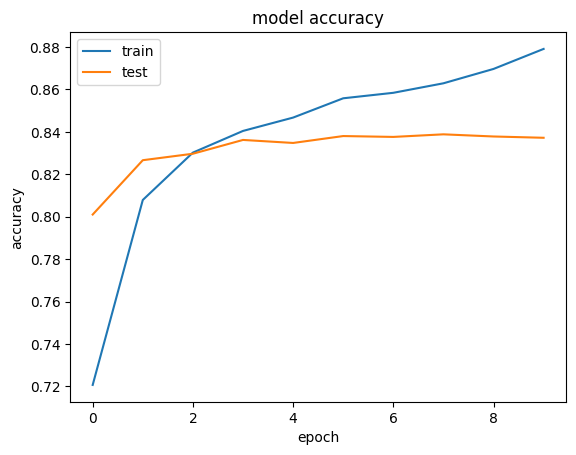

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()



In [38]:
y_pred = model_4_fast_text.predict(test_description_padded, batch_size=64)
y_class = prob_to_class(y_pred)
print(y_class)

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step
[[1. 0. 0.]
 [0. 1. 1.]
 [0. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 0.]]


In [40]:
import tensorflow as tf

# Defining hamming loss
def f1_score(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.math.greater(y_pred, threshold), tf.float32)
    global true_positives
    true_positives = tf.reduce_sum(tf.cast(tf.math.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32), axis=0)
    global predicted_positives
    predicted_positives = tf.reduce_sum(y_pred, axis=0)
    global actual_positives
    actual_positives = tf.reduce_sum(y_true, axis=0)
    global precision
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    global recall
    recall = true_positives / (actual_positives + tf.keras.backend.epsilon())
    global f1
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return tf.reduce_mean(f1)

def hamming_loss(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(tf.math.greater(y_pred, threshold), tf.float32)
    global hamming_losss
    hamming_losss = 1 - tf.reduce_mean(tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32), axis=1))
    return hamming_losss

# Assuming y_test and y_pred are defined
# Compute F1 Score and Hamming Loss
f1_score_value = f1_score(y_test, y_pred)
hamming_loss_value = hamming_loss(y_test, y_pred)

# Print the results
print('Hamming Loss:', hamming_loss_value.numpy())
print('hamming score:',1-hamming_loss_value.numpy())

Hamming Loss: 0.16280496
hamming score: 0.8371950387954712


In [42]:
# Example of custom input
custom_input_text = ["touching"]

custom_input_sequences = tokenizer.texts_to_sequences(custom_input_text)
custom_input_padded = pad_sequences(custom_input_sequences, maxlen=300, dtype='int32', padding='post', truncating='post')


custom_predictions = model_4_fast_text.predict(custom_input_padded)

custom_class_labels = prob_to_class(custom_predictions)

print("Predicted probabilities for custom input:")
print(custom_predictions)
print("Predicted class labels for custom input:")
print(custom_class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted probabilities for custom input:
[[0.2775726  0.21169014 0.9454461 ]]
Predicted class labels for custom input:
[[0. 0. 1.]]
